In [99]:
import sigfig
import polars as pl
from refnx.analysis import Transform, GlobalObjective

import pyref.fitting as fit
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Load In DFT NEXAFS


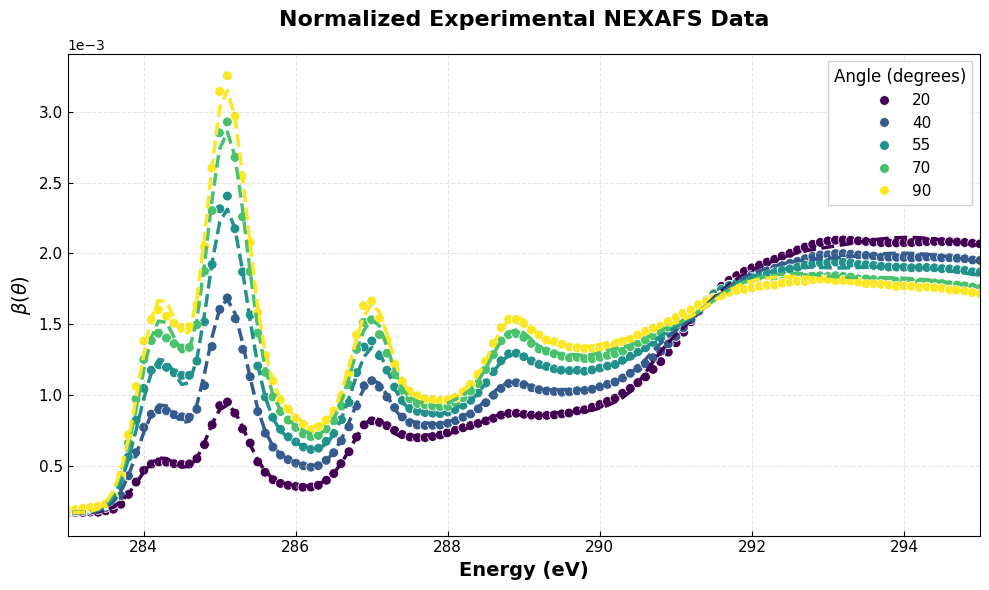

In [103]:
import seaborn as sns

# Load the already normalized NEXAFS data
raw = pd.read_csv("normalized_nexafs.csv")
dft = pd.read_csv("normalized_dft_nexafs.csv")

# Create a nice and pretty plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    data=raw,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    s=50,
    ax=ax,
    alpha=1,
)
sns.lineplot(
    data=dft,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    linewidth=2.5,
    linestyle="--",
    ax=ax,
    legend=False,
)

# Customize the plot
ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Normalized Experimental NEXAFS Data", fontsize=16, fontweight="bold", pad=20
)
# Use scientific notation for y-axis
ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax.set_xlim(283, 295)

# Customize legend
legend = ax.legend(
    title="Angle (degrees)",
    title_fontsize=12,
    fontsize=11,
    frameon=True,
    fancybox=False,
    shadow=False,
)
legend.get_frame().set_facecolor("white")
legend.get_frame().set_alpha(0.9)

# Add grid and styling
ax.grid(True, alpha=0.3, linestyle="--")
ax.tick_params(direction="in", labelsize=11)

# Adjust layout and save
plt.tight_layout()
# plt.savefig("nexafs_normalized.png", dpi=300, bbox_inches="tight")
plt.show()

In [104]:
from scipy.ndimage import gaussian_filter1d

dft = raw
energy_step = round(dft["Energy"].diff().mean(), 2) / 10
#  create a common energy axis for all pairs
common_energy_steep = np.arange(
    round(dft["Energy"].min(), 2),
    round(dft["Energy"].max(), 2) + energy_step,
    energy_step,
)
common_energy = np.arange(
    round(dft["Energy"].min(), 2),
    round(dft["Energy"].max(), 2) + energy_step * 10,
    energy_step * 10,
)
interpolated_dfts = []
for angle in dft["Angle"].unique():
    angle_data = dft[dft["Angle"] == angle].copy()
    #  Apply a gaussian filter 1d to smooth the data before interpolation
    angle_data["Normalized Intensity"] = gaussian_filter1d(
        angle_data["Normalized Intensity"], sigma=1, radius=10
    )
    interpolated_dft = np.interp(
        common_energy_steep, angle_data["Energy"], angle_data["Normalized Intensity"]
    )
    interpolated_dft = gaussian_filter1d(interpolated_dft, sigma=10, radius=40)
    #  Re interpolate to the common energy axis
    interpolated_dft = np.interp(common_energy, common_energy_steep, interpolated_dft)
    #  Create a DataFrame for the interpolated data
    interpolated_dfts.append(
        pd.DataFrame(
            {
                "Energy": common_energy,
                "Normalized Intensity": interpolated_dft,
                "Angle": angle,
            }
        )
    )

dft = pd.concat(interpolated_dfts, ignore_index=True)
print(energy_step)

0.002


<Axes: xlabel='Energy', ylabel='Normalized Intensity'>

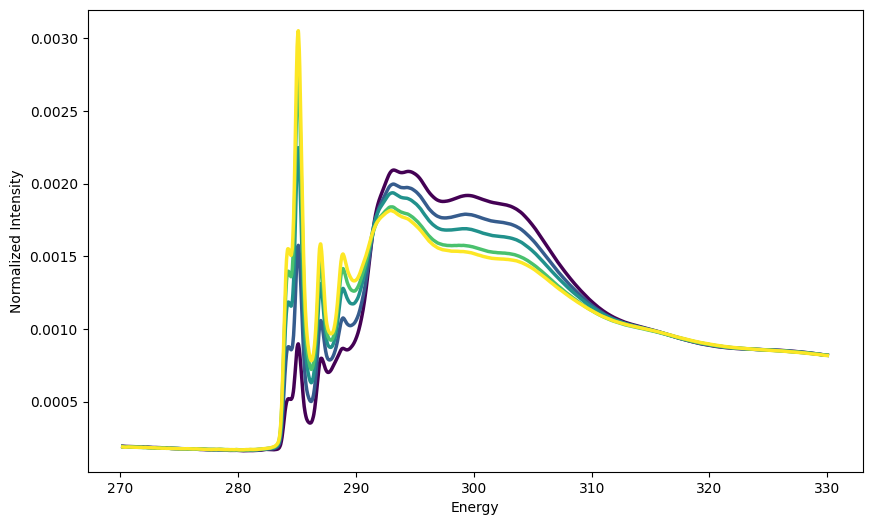

In [105]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=dft,
    x="Energy",
    y="Normalized Intensity",
    hue="Angle",
    palette="viridis",
    linewidth=2.5,
    linestyle="-",
    ax=ax,
    legend=False,
)

In [106]:
dft["Energy"].unique()

array([270.2 , 270.22, 270.24, ..., 329.96, 329.98, 330.  ], shape=(2991,))

<Axes: xlabel='Energy', ylabel='Difference'>

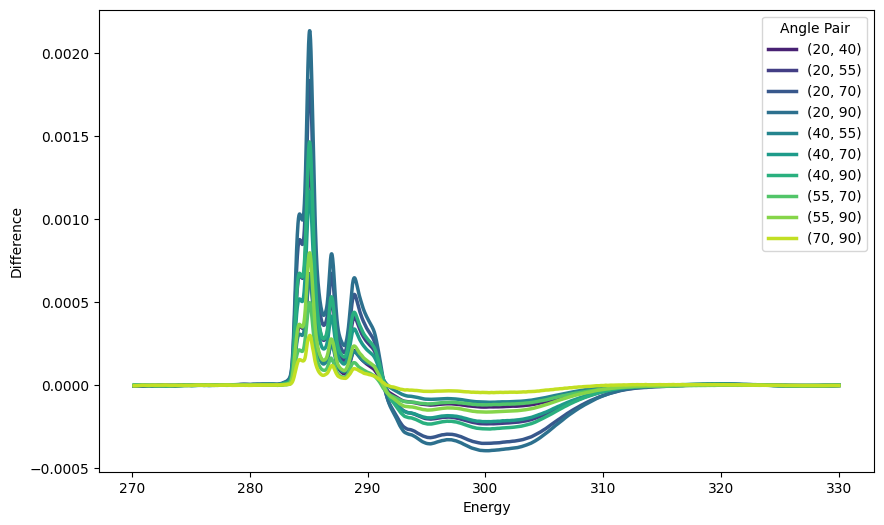

In [107]:
import itertools

#  Calculate the difference spectrum between each parining of high angles and low angles
angles = dft["Angle"].unique()
angle_pairs = [
    (low, high) for low, high in itertools.combinations(angles, 2) if low < high
]
# Compute the differnce between the dft_fit spectrum for each of these pairs and plot
fig, ax = plt.subplots(figsize=(10, 6))

diff_spectra = []
for low, high in angle_pairs:
    low_data = dft[dft["Angle"] == low]["Normalized Intensity"].values
    high_data = dft[dft["Angle"] == high]["Normalized Intensity"].values
    energy = dft[dft["Angle"] == low]["Energy"].values
    diff = high_data - low_data
    #  Apply a gaussian filter 1d to smooth the data before interpolation
    diff = gaussian_filter1d(diff, sigma=2, radius=5)
    #  Interpolate the difference spectrum to the common energy axis
    diff = np.interp(common_energy, energy, diff)
    diff_spectra.append(
        pd.DataFrame(
            {
                "Energy": energy,
                "Difference": diff,
                "Angle Pair": [f"{(int(low), int(high))}"] * len(energy),
            }
        )
    )

diff_df = pd.concat(diff_spectra, ignore_index=True)
sns.lineplot(
    data=diff_df,
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    palette="viridis",
    linewidth=2.5,
    ax=ax,
)

In [108]:
# Grab the energy associated with the maximum difference
max_diff = diff_df["Difference"].max()
diff_spec_max = diff_df[diff_df["Difference"] == diff_df["Difference"].max()][
    "Energy"
].values[0]

# Apply normalization using groupby
scaled_diff = (
    diff_df.groupby("Angle Pair")
    .apply(
        lambda group: group.assign(
            Difference=group["Difference"] / group["Difference"].max() * max_diff
        ),
    )
    .reset_index(level=0, drop=True)
)

# calculate the mean and std of the difference spectra
avg_diff = scaled_diff.groupby("Energy")["Difference"].median().reset_index()
std_diff = scaled_diff.groupby("Energy")["Difference"].std().reset_index()
avg_diff["Energy"].unique()

/tmp/ipykernel_1475975/2286156583.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


array([270.2 , 270.22, 270.24, ..., 329.96, 329.98, 330.  ], shape=(2991,))

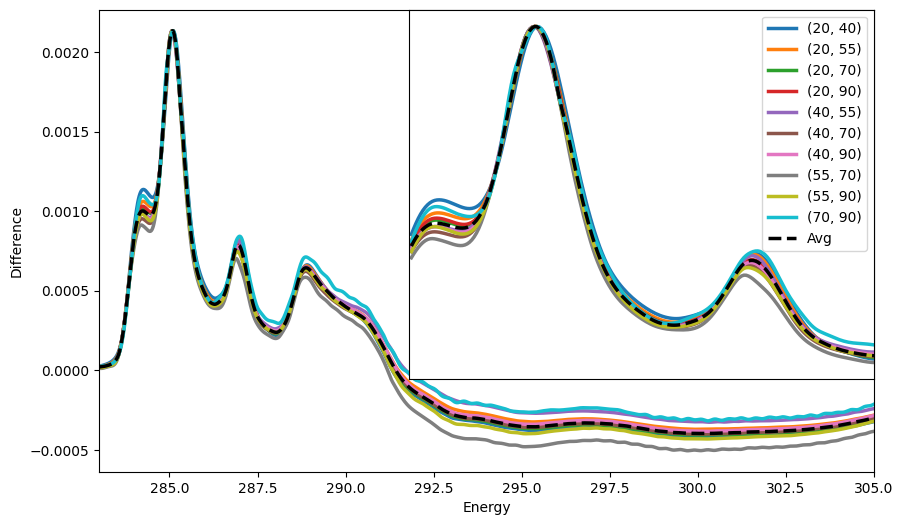

In [109]:
# Create the plot outside the groupby operation
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=scaled_diff,
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=avg_diff,
    x="Energy",
    y="Difference",
    label="Average Difference Spectrum",
    linewidth=2.5,
    ax=ax,
    color="black",
    linestyle="--",
)

# Create an inset axis from 284 - 287
inset_ax = ax.inset_axes(
    [0.4, 0.2, 0.6, 0.8], xticklabels=[], yticklabels=[]
)  # [x, y, width, height]
inset_ax.set_xlim(284, 288)
sns.lineplot(
    data=scaled_diff[(scaled_diff["Energy"] >= 284) & (scaled_diff["Energy"] <= 288)],
    x="Energy",
    y="Difference",
    hue="Angle Pair",
    linewidth=2.5,
    ax=inset_ax,
)
sns.lineplot(
    data=avg_diff[(avg_diff["Energy"] >= 284) & (avg_diff["Energy"] <= 288)],
    x="Energy",
    y="Difference",
    label="Avg",
    linewidth=2.5,
    ax=inset_ax,
    color="black",
    linestyle="--",
)
# remove labels
inset_ax.set_xlabel("")
inset_ax.set_ylabel("")
# remove ticks
inset_ax.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)
# inset_ax.legend().remove()

# turn off the legend
ax.legend().remove()
ax.set_xlim(283, 305)
plt.show()

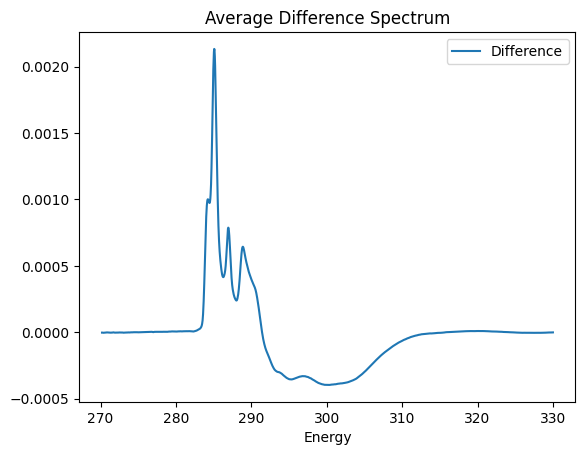

In [110]:
# Get sig figs of the first value and round the average difference spectrum
sig_figs = np.floor(np.log10(np.abs(avg_diff["Difference"].iloc[0])))
# avg_diff["Difference"] = #avg_diff["Difference"].apply(
#     lambda x: round(x, int(abs(sig_figs) - 2))
# )
avg_diff.plot(
    x="Energy",
    y="Difference",
    title="Average Difference Spectrum",
)
avg_diff.to_csv("average_difference_spectrum_exp.csv", index=False)

In [111]:
# Use the difference spectrum to calculate the in and out of plane optical constants
#  Grab the magic angle 55 degree spectrum
magic_angle = 55
oc_dfs = (
    dft[dft["Angle"] == magic_angle]
    .copy()
    .rename(columns={"Normalized Intensity": "βiso"})
).reset_index(drop=True)
# drop angle
oc_dfs = oc_dfs.drop(columns=["Angle"])
oc_dfs["Energy"] = oc_dfs["Energy"].round(3)
# Add the difference spectrum to the optical constants dataframe
oc_dfs["Difference"] = avg_diff["Difference"]
oc_dfs

,Energy,βiso,Difference
0,270.20,0.000188,-0.000003
1,270.22,0.000188,-0.000003
2,270.24,0.000188,-0.000003
3,270.26,0.000188,-0.000003
4,270.28,0.000188,-0.000004
...,...,...,...
2986,329.92,0.000818,-0.000002
2987,329.94,0.000818,-0.000002
2988,329.96,0.000817,-0.000002
2989,329.98,0.000817,-0.000002


(283.0, 332.99)

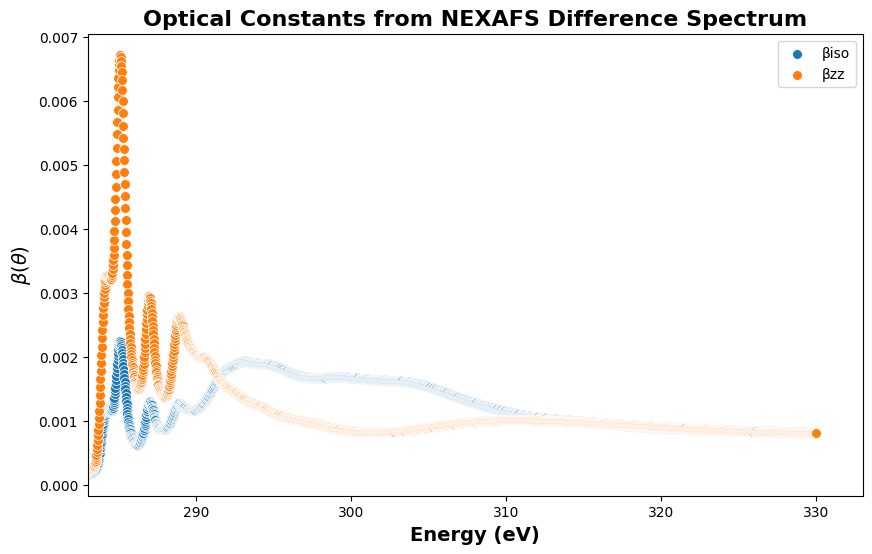

In [112]:
dipole_orientation = np.deg2rad(0)
dipole_energy = 285.06
dipole_iso = oc_dfs["βiso"].loc[oc_dfs["Energy"] == dipole_energy].values[0]
dipole_diff = oc_dfs["Difference"].loc[oc_dfs["Energy"] == dipole_energy].values[0]

scale_param = (3 * np.cos(dipole_orientation) ** 2 - 1) * dipole_iso / dipole_diff
oc_dfs["βzz"] = oc_dfs["βiso"] + scale_param * oc_dfs["Difference"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    s=50,
    ax=ax,
)
sns.scatterplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    s=50,
    ax=ax,
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(283, None)

(280.0, 332.99)

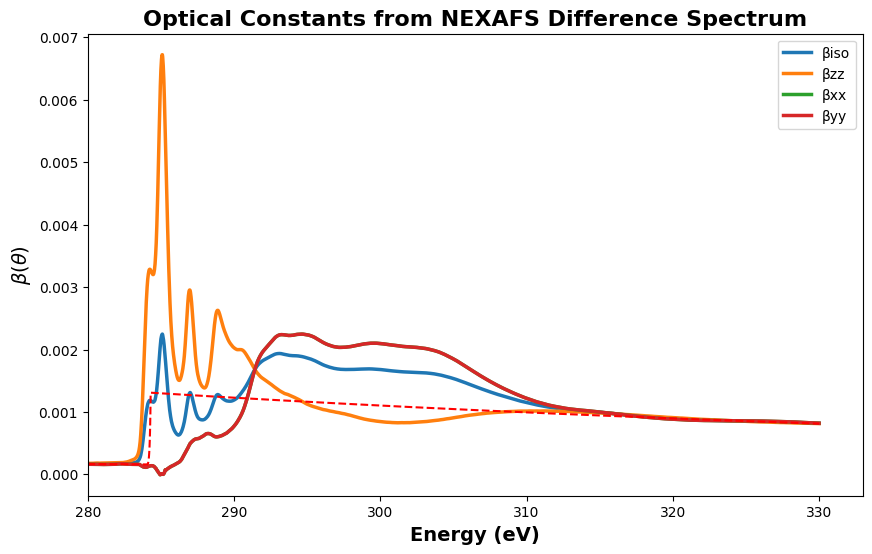

In [ ]:
import periodictable.xsf as xsf

full_bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=oc_dfs["Energy"] * 1e-3
)

scale_in_plane = dipole_iso / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βyy",
    label="βyy",
    linewidth=2.5,
    ax=ax,
)

ax.plot(
    oc_dfs["Energy"],
    -full_bare_atom.imag,
    label="β from xsf",
    linestyle="--",
    color="red",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, None)

In [74]:
oc_dfs[(oc_dfs["Energy"] <= 282)]

,Energy,βiso,Difference,βzz,βxx,βyy
0,270.20,0.000188,-0.000003,0.000181,0.000191,0.000191
1,270.22,0.000188,-0.000003,0.000181,0.000191,0.000191
2,270.24,0.000188,-0.000003,0.000182,0.000191,0.000191
3,270.26,0.000188,-0.000003,0.000181,0.000192,0.000192
4,270.28,0.000188,-0.000004,0.000181,0.000192,0.000192
...,...,...,...,...,...,...
586,281.92,0.000171,0.000007,0.000186,0.000163,0.000163
587,281.94,0.000171,0.000007,0.000186,0.000163,0.000163
588,281.96,0.000171,0.000007,0.000186,0.000164,0.000164
589,281.98,0.000171,0.000007,0.000186,0.000164,0.000164


Text(0.5, 1.0, 'Optical Constants with Polynomial Fit')

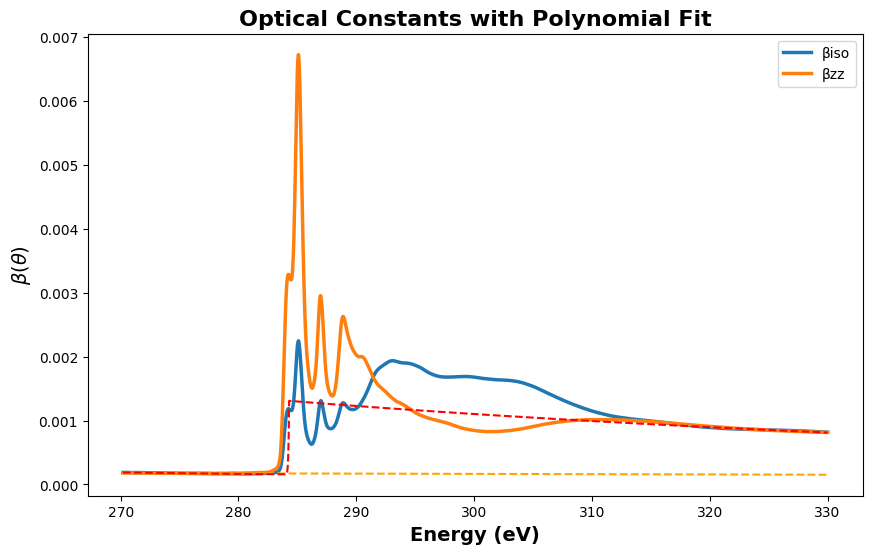

In [82]:
# Fit the pre edge region to a polynomial
pre_edge_region = oc_dfs[(oc_dfs["Energy"] <= 280)]
poly_fit = np.polyfit(pre_edge_region["Energy"], pre_edge_region["βzz"], 1)
poly_func = np.poly1d(poly_fit)
# Plot the data and the polynomial fit
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)
ax.plot(
    oc_dfs["Energy"],
    -full_bare_atom.imag,
    label="β from xsf",
    linestyle="--",
    color="red",
)
ax.set_xlim(None, None)
ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title("Optical Constants with Polynomial Fit", fontsize=16, fontweight="bold")

(0.0, 0.001)

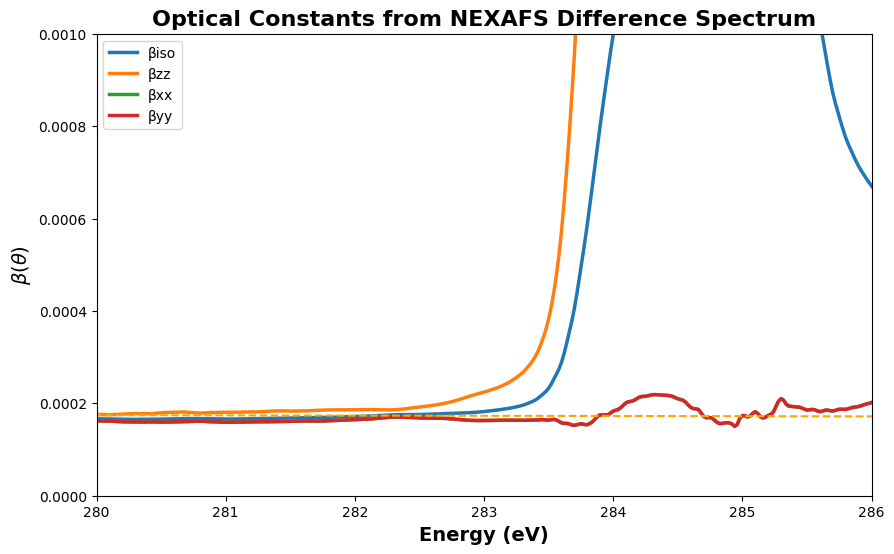

In [83]:
scale_in_plane_corrected = (dipole_iso - poly_func(dipole_energy)) / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane_corrected * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βyy",
    label="βyy",
    linewidth=2.5,
    ax=ax,
)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, 286)
ax.set_ylim(0, 0.001)

(0.0, 0.001)

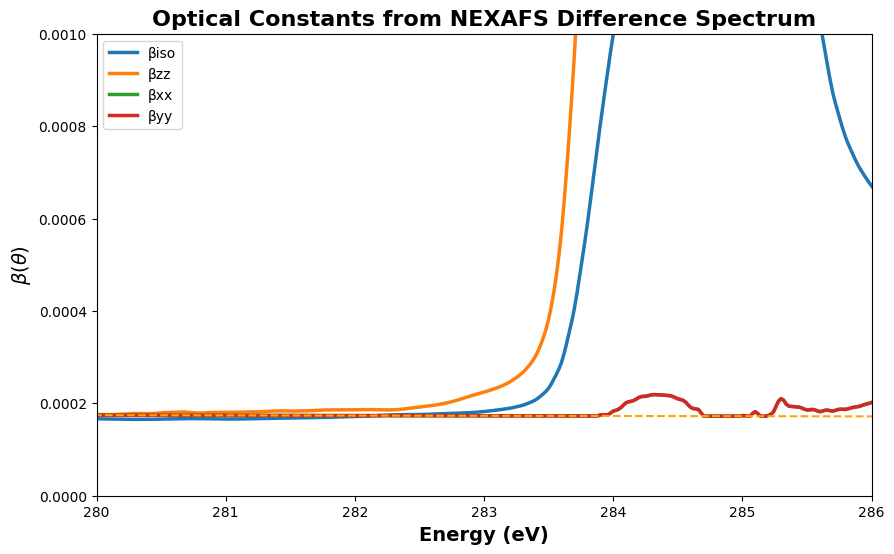

In [84]:
scale_in_plane_final = (
    dipole_iso * (1 - 0.5 * np.sin(dipole_orientation) ** 2) - poly_func(dipole_energy)
) / dipole_diff
oc_dfs["βxx"] = oc_dfs["βiso"] - scale_in_plane_final * oc_dfs["Difference"]
oc_dfs["βyy"] = oc_dfs["βxx"]

# Clip less than the polynomial fit
oc_dfs["βzz"] = np.clip(oc_dfs["βzz"], poly_func(oc_dfs["Energy"]), None)
oc_dfs["βxx"] = np.clip(oc_dfs["βxx"], poly_func(oc_dfs["Energy"]), None)
oc_dfs["βyy"] = np.clip(oc_dfs["βyy"], poly_func(oc_dfs["Energy"]), None)
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(data=oc_dfs, x="Energy", y="βyy", label="βyy", linewidth=2.5, ax=ax)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)
ax.set_xlim(280, 286)
ax.set_ylim(0, 0.001)

(0.00015, 0.0005)

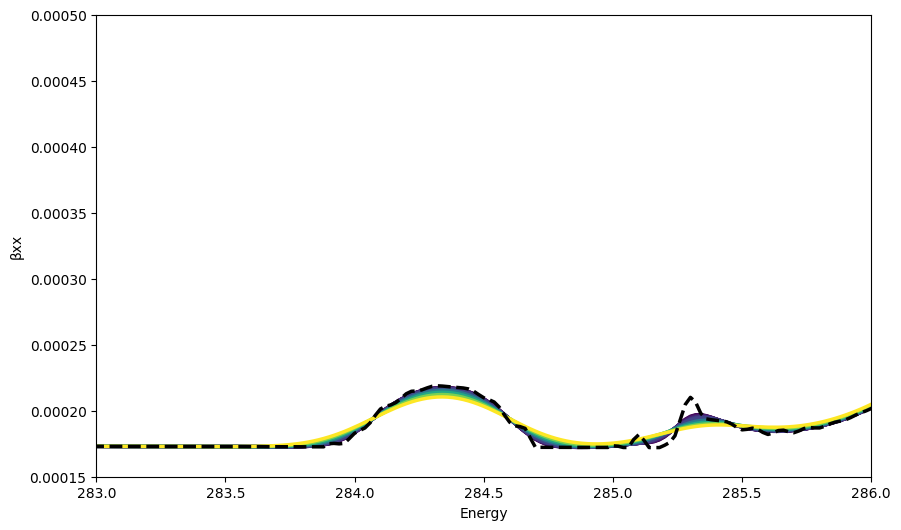

In [85]:
oc_filtered = oc_dfs.copy()
oc_filtered["sigma"] = 0
filter_sigms = [3, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4, 5, 6, 7, 8]
filtered_dfs = []
for sigm in filter_sigms:
    temp_df = oc_filtered.copy()
    # Apply a 1d gaussian filter to smooth the data
    temp_df["βiso"] = gaussian_filter1d(temp_df["βiso"], sigma=sigm)
    temp_df["βzz"] = gaussian_filter1d(temp_df["βzz"], sigma=sigm)
    temp_df["βxx"] = gaussian_filter1d(temp_df["βxx"], sigma=sigm)
    temp_df["βyy"] = gaussian_filter1d(temp_df["βyy"], sigma=sigm)
    temp_df["sigma"] = sigm
    filtered_dfs.append(temp_df)
oc_filtered = pd.concat(filtered_dfs, ignore_index=True)

# plot the optical constants with the rolling mean applied
fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(
#     data=oc_filtered,
#     x="Energy",
#     y="βzz",
#     hue="sigma",
#     palette="viridis",
#     linewidth=2.5,
#     ax=ax,
# )
# sns.lineplot(
#     data=oc_dfs,
#     x="Energy",
#     y="βzz",
#     label="βzz (no smoothing)",
#     linewidth=2.5,
#     ax=ax,
#     color="black",
#     linestyle="--",
# )
sns.lineplot(
    data=oc_filtered,
    x="Energy",
    y="βxx",
    hue="sigma",
    palette="viridis",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx (no smoothing)",
    linewidth=2.5,
    ax=ax,
    color="black",
    linestyle="--",
)
#  turn off the legend
ax.legend().remove()
ax.set_xlim(283, 286)
ax.set_ylim(0.00015, 0.0005)

Text(0.5, 1.0, 'Optical Constants from NEXAFS Difference Spectrum')

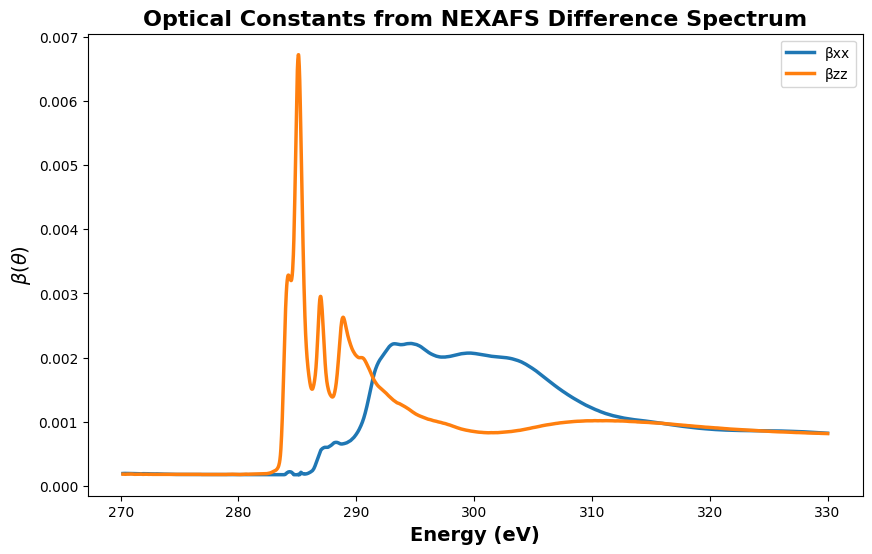

In [86]:
# Lets use the 0 beta xx trace
oc_dfs["βxx"] = oc_dfs["βxx"]
oc_dfs["βyy"] = oc_dfs["βxx"]

# plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)

ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")
ax.set_ylabel(r"$\beta (\theta)$", fontsize=14, fontweight="bold")
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=16, fontweight="bold"
)

In [87]:
oc_dfs.to_csv("optical_constants_beta_exp.csv", index=False)

(283.0, 305.0)

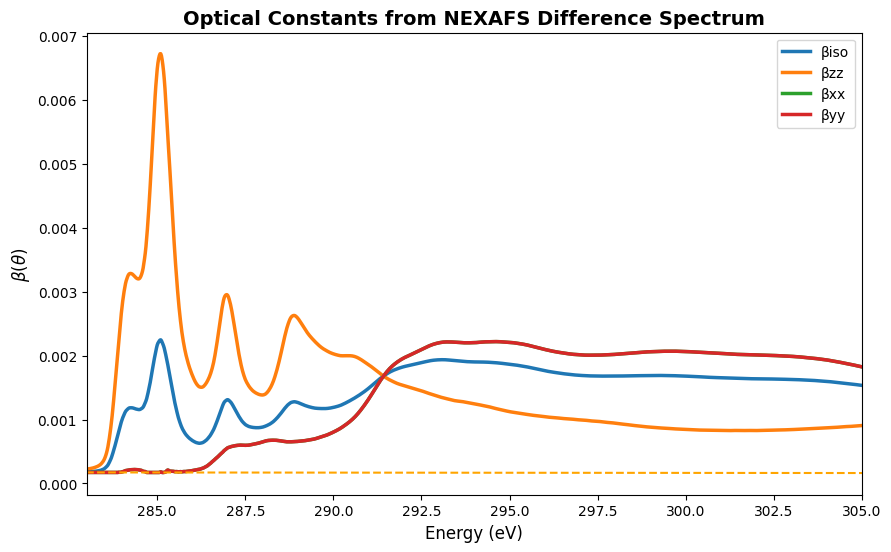

In [88]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βiso",
    label="βiso",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βzz",
    label="βzz",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(
    data=oc_dfs,
    x="Energy",
    y="βxx",
    label="βxx",
    linewidth=2.5,
    ax=ax,
)
sns.lineplot(data=oc_dfs, x="Energy", y="βyy", label="βyy", linewidth=2.5, ax=ax)

ax.plot(
    oc_dfs["Energy"],
    poly_func(oc_dfs["Energy"]),
    label="Polynomial Fit",
    linestyle="--",
    color="orange",
)

ax.set_xlabel("Energy (eV)", fontsize=12)
ax.set_ylabel(r"$\beta (\theta)$", fontsize=12)
ax.set_title(
    "Optical Constants from NEXAFS Difference Spectrum", fontsize=14, fontweight="bold"
)
ax.set_xlim(283, 305)

In [89]:
from kkcalc import kk

# Now we need to use the kramers kronig relations to calculate the real part of the refractive index
calc_e = kk.kk_calculate_real(
    oc_dfs[["Energy", "βzz"]].values,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[oc_dfs["Energy"].min(), oc_dfs["Energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)
calc_o = kk.kk_calculate_real(
    oc_dfs[["Energy", "βxx"]].values,
    "C32H16N8Zn1",
    input_data_type="beta",
    load_options=None,
    merge_points=[oc_dfs["Energy"].min(), oc_dfs["Energy"].max()],
    add_background=False,
    curve_tolerance=0.01,
    curve_recursion=100,
)

stoichiometry = kk.data.ParseChemicalFormula("C32H16N8Zn1")
mass = kk.data.calculate_FormulaMass(stoichiometry)

δxx = kk.data.convert_data(
    calc_o[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)
δzz = kk.data.convert_data(
    calc_e[:, [0, 1]], "ASF", "refractive_index", Density=1, Formula_Mass=mass
)
βxx = kk.data.convert_data(
    calc_o[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)
βzz = kk.data.convert_data(
    calc_e[:, [0, 2]], "ASF", "beta", Density=1, Formula_Mass=mass
)

Text(0.5, 0, 'Energy (eV)')

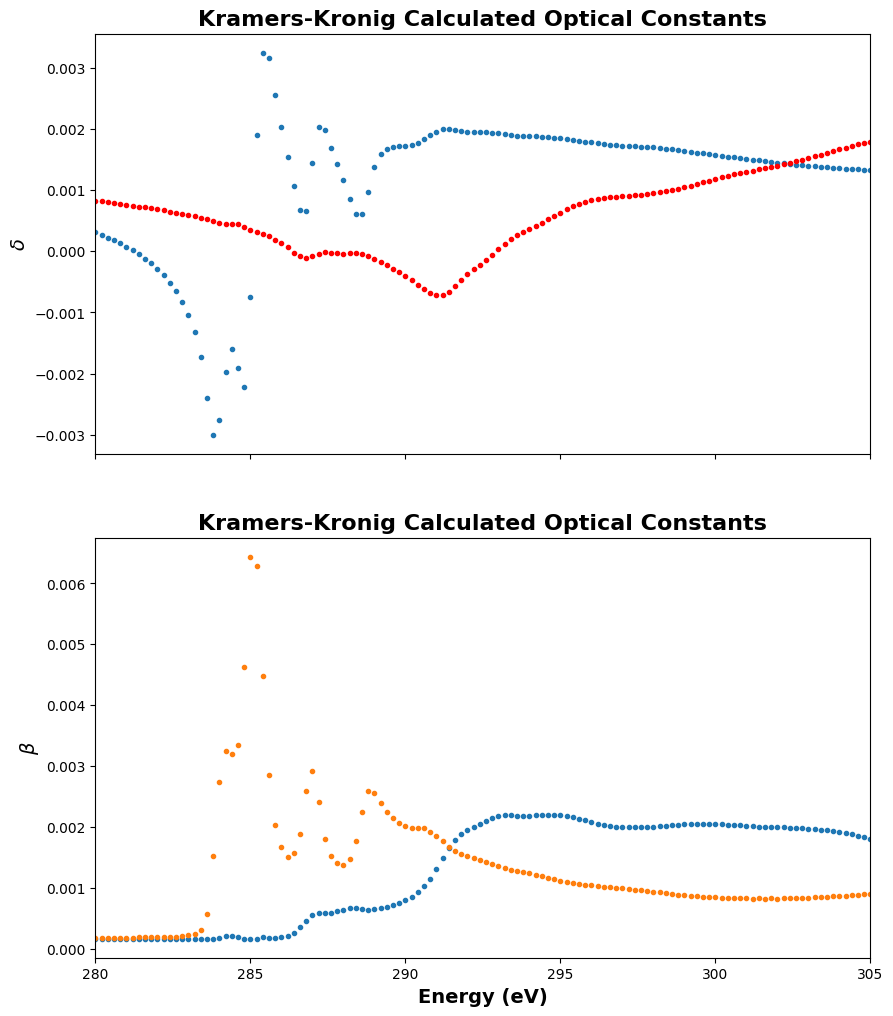

In [116]:
# Grab the unique energies
# Grab every other energy for the 55° spectrum
energies = dft[dft["Angle"] == 55]["Energy"].values[::10]
# Create a DataFrame with the energies and the corresponding values
oc_kk = pd.DataFrame(
    {
        "Energy": energies,
        "δxx": np.interp(energies, δxx[:, 0], δxx[:, 1]),
        "δzz": np.interp(energies, δzz[:, 0], δzz[:, 1]),
        "βxx": np.interp(energies, βxx[:, 0], βxx[:, 1]),
        "βzz": np.interp(energies, βzz[:, 0], βzz[:, 1]),
    }
)

fig, (delta_ax, beta_ax) = plt.subplots(
    2, 1, figsize=(10, 12), sharex=True, gridspec_kw={"height_ratios": [1, 1]}
)

# zoom into the energy range of 280 - 305 eV
delta_ax.set_xlim(280, 305)
beta_ax.set_xlim(280, 305)
filter = (oc_kk["Energy"] >= 280) & (oc_kk["Energy"] <= 305)
delta_ax.set_ylabel(r"$\delta$", fontsize=14, fontweight="bold")
delta_ax.set_title(
    "Kramers-Kronig Calculated Optical Constants", fontsize=16, fontweight="bold"
)

beta_ax.plot(
    oc_kk["Energy"],
    oc_kk["βxx"],
    ".",
    label="βxx",
)
beta_ax.plot(
    oc_kk["Energy"],
    oc_kk["βzz"],
    ".",
    label="βyy",
)
delta_ax.plot(
    oc_kk["Energy"],
    oc_kk["δzz"],
    ".",
    label="δzz",
)
delta_ax.plot(
    oc_kk["Energy"],
    oc_kk["δxx"],
    ".",
    label="δxx",
    color="red",
)

beta_ax.set_ylabel(r"$\beta$", fontsize=14, fontweight="bold")
beta_ax.set_title(
    "Kramers-Kronig Calculated Optical Constants", fontsize=16, fontweight="bold"
)
beta_ax.set_xlabel("Energy (eV)", fontsize=14, fontweight="bold")

In [98]:
#  Rename deltas to use xx and zz, and betas to use ixx and izz
oc_kk.rename(
    columns={
        "Energy": "energy",
        "δxx": "n_xx",
        "δzz": "n_zz",
        "βxx": "n_ixx",
        "βzz": "n_izz",
    }
).to_csv("optical_constants_exp.csv", index=False)

# Load Optical Constants for Constraints and OOC instantiation


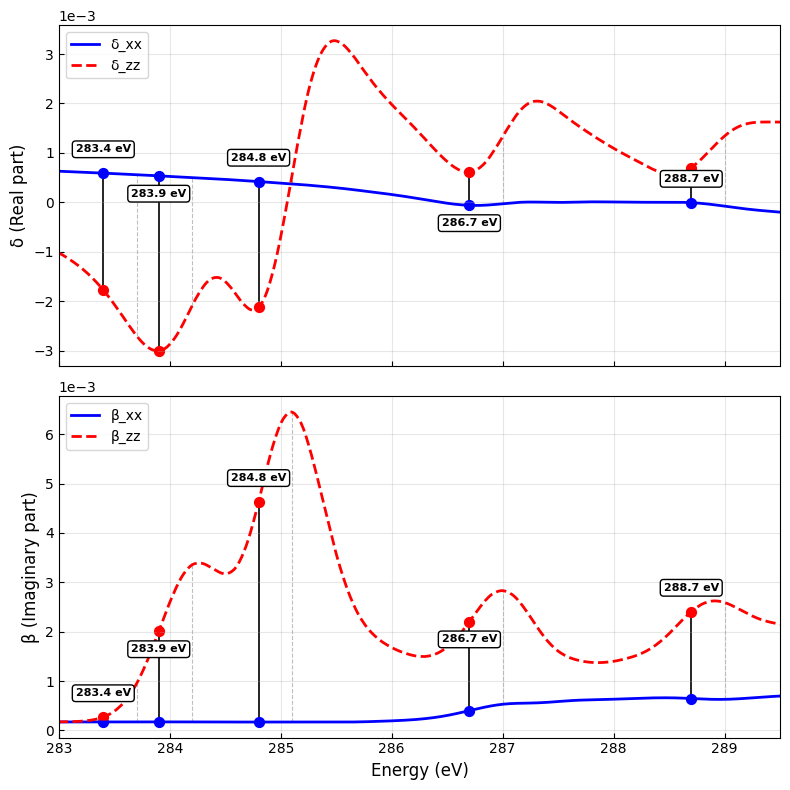

In [141]:
ooc = pd.read_csv("optical_constants.csv")
# We need to
energy_batches = [
    [],
    [
        250.0,
        275.0,
        280.0,
        281.0,
        281.2,
        281.4,
        281.6,
        281.8,
        282.0,
        282.3,
        282.5,
        282.7,
        282.9,
        283.1,
        283.3,
        283.5,
        283.7,
        284.2,
        285.1,
        287.0,
        289.0,
    ],
]


def ooc_func(energy):
    """Get optical constants for a given energy."""
    #  return the interpolated values for a given energy
    n_xx = np.interp(energy, ooc["energy"], ooc["n_xx"])
    n_zz = np.interp(energy, ooc["energy"], ooc["n_zz"])
    n_ixx = np.interp(energy, ooc["energy"], ooc["n_ixx"])
    n_izz = np.interp(energy, ooc["energy"], ooc["n_izz"])
    return n_xx, n_zz, n_ixx, n_izz


# Create a cleaner plot with better layout - stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 245) & (ooc["energy"] <= 295)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_xx"], "b-", linewidth=2, label="δ_xx"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_zz"], "r--", linewidth=2, label="δ_zz"
)
ax1.set_ylabel("δ (Real part)", fontsize=12)
ax1.legend(loc="upper left")
ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

# Zoomed view of imaginary parts around absorption edge
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_ixx"], "b-", linewidth=2, label="β_xx"
)
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_izz"], "r--", linewidth=2, label="β_zz"
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e < 283.7:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )
    # if the energy is >= 283.7 eV annotate the point with a box and bold text
    if e >= 283.7:
        ax1.annotate(
            f"{e + en_shift:.1f} eV",
            (e + en_shift, n_xx_shifted),
            textcoords="offset points",
            xytext=(0, 15 if i % 2 == 0 else -15),
            ha="center",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
            fontweight="bold",
        )
        ax2.annotate(
            f"{e + en_shift:.1f} eV",
            (e + en_shift, n_izz_shifted),
            textcoords="offset points",
            xytext=(0, 15 if i % 2 == 0 else -15),
            ha="center",
            fontsize=8,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
            fontweight="bold",
        )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(283, 289.5)

# Adjust layout and show
plt.tight_layout()
plt.show()

# offset_energies = [energy_batches[0] + en_shift, energy_batches[1] + en_shift]

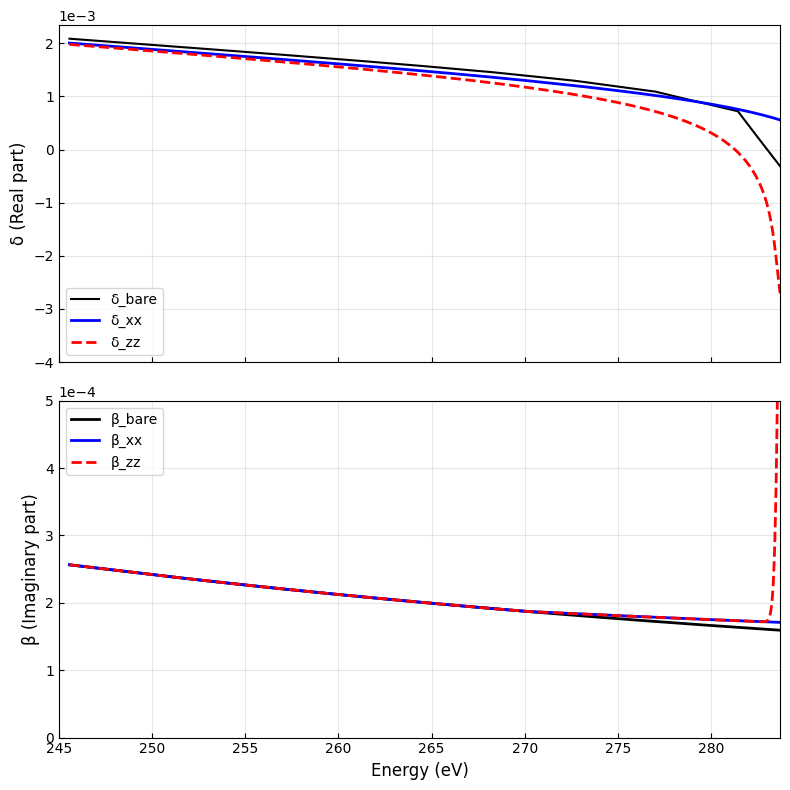

In [130]:
import periodictable.xsf as xsf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 245) & (ooc["energy"] <= 284.5)
bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc.loc[mask, "energy"] * 1e-3
)
ax1.plot(
    ooc.loc[mask, "energy"], 1 - bare_atom.real, "k", linewidth=1.5, label="δ_bare"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_xx"], "b-", linewidth=2, label="δ_xx"
)
ax1.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_zz"], "r--", linewidth=2, label="δ_zz"
)
ax1.set_ylabel("δ (Real part)", fontsize=12)

ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

ax1.set_ylim((-4e-3))
ax1.legend(loc="lower left")

ax2.plot(ooc.loc[mask, "energy"], -bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_ixx"], "b-", linewidth=2, label="β_xx"
)
ax2.plot(
    ooc.loc[mask, "energy"], ooc.loc[mask, "n_izz"], "r--", linewidth=2, label="β_zz"
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax2.set_ylim(0, 5e-4)

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e not in energy_batches[0]:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )

    ax1.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_xx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )
    ax2.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_ixx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(245, 283.7)

# Adjust layout and show
plt.tight_layout()
plt.show()

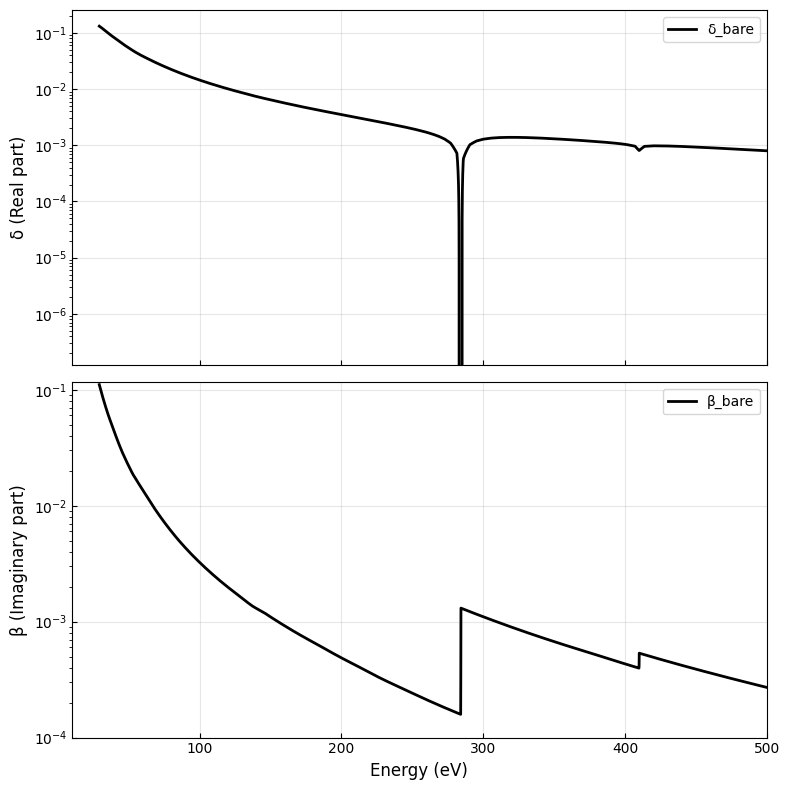

In [132]:
full_bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc["energy"] * 1e-3
)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax1.plot(ooc["energy"], 1 - full_bare_atom.real, "k", linewidth=2, label="δ_bare")
ax1.set_ylabel("δ (Real part)", fontsize=12)
ax1.set_yscale("log")
ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.legend()

ax2.plot(ooc["energy"], -full_bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.set_ylim((1e-4, None))
ax2.set_yscale("log")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.legend()

for ax in [ax1, ax2]:
    ax.set_xlim(10, 500)

plt.tight_layout()
plt.show()

In [47]:
def calculate_normalization_factors(normalization_energy=250):
    """
    Calculate normalization factors for optical constants.

    Parameters:
    -----------
    normalization_energy : float, optional
        Energy in eV to use for normalization (default: 250)

    Returns:
    --------
    tuple : (xx_norm, zz_norm, ixx_norm, izz_norm)
        Normalization factors for n_xx, n_zz, n_ixx, n_izz
    """
    # Get optical constants at normalization energy
    nxx, nzz, nixx, nizz = ooc_func(normalization_energy)

    # Calculate bare atom optical constants
    bare_atom = xsf.index_of_refraction(
        "C32H16N8Zn1", density=1, energy=normalization_energy * 1e-3
    )

    # Calculate normalization factors
    xx_norm = (1 - bare_atom.real) / nxx
    zz_norm = (1 - bare_atom.real) / nzz
    ixx_norm = -bare_atom.imag / nixx
    izz_norm = -bare_atom.imag / nizz

    print(
        f"Normalization factors:\n"
        f"n_xx: {xx_norm:.4f}, n_zz: {zz_norm:.4f}, n_ixx: {ixx_norm:.4f}, n_izz: {izz_norm:.4f}"
    )

    return xx_norm, zz_norm, ixx_norm, izz_norm


# Calculate normalization factors
xx_norm, zz_norm, ixx_norm, izz_norm = calculate_normalization_factors()

Normalization factors:
n_xx: 0.9567, n_zz: 0.9262, n_ixx: 0.8619, n_izz: 0.8619


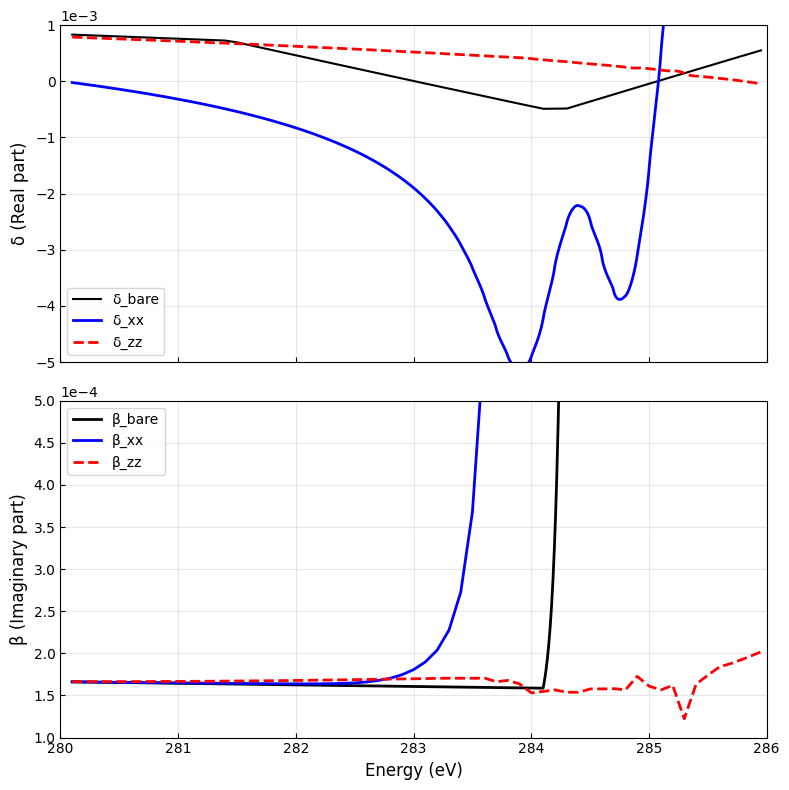

In [38]:
import periodictable.xsf as xsf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
# Zoomed view of real parts around absorption edge
mask = (ooc["energy"] >= 280) & (ooc["energy"] <= 286)
bare_atom = xsf.index_of_refraction(
    "C32H16N8Zn1", density=1, energy=ooc.loc[mask, "energy"] * 1e-3
)
ax1.plot(
    ooc.loc[mask, "energy"], 1 - bare_atom.real, "k", linewidth=1.5, label="δ_bare"
)
ax1.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_xx"] * xx_norm,
    "b-",
    linewidth=2,
    label="δ_xx",
)
ax1.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_zz"] * zz_norm,
    "r--",
    linewidth=2,
    label="δ_zz",
)
ax1.set_ylabel("δ (Real part)", fontsize=12)

ax1.grid(True, alpha=0.3)
ax1.tick_params(direction="in")
ax1.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

ax1.set_ylim((-5e-3, 1e-3))
ax1.legend(loc="lower left")

ax2.plot(ooc.loc[mask, "energy"], -bare_atom.imag, "k", linewidth=2, label="β_bare")
ax2.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_ixx"] * ixx_norm,
    "b-",
    linewidth=2,
    label="β_xx",
)
ax2.plot(
    ooc.loc[mask, "energy"],
    ooc.loc[mask, "n_izz"] * izz_norm,
    "r--",
    linewidth=2,
    label="β_zz",
)
ax2.set_ylabel("β (Imaginary part)", fontsize=12)
ax2.set_xlabel("Energy (eV)", fontsize=12)
ax2.legend(loc="upper left")
ax2.grid(True, alpha=0.3)
ax2.tick_params(direction="in")
ax2.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))
ax2.set_ylim(1e-4, 5e-4)

en_shift = -0.3

# Draw vertical lines at the measurement energies
for i, e in enumerate(energy_batches[1]):
    if e not in energy_batches[0]:
        continue
    n_xx, n_zz, n_ixx, n_izz = ooc_func(e)
    n_xx_shifted, n_zz_shifted, n_ixx_shifted, n_izz_shifted = ooc_func(e + en_shift)
    n_xx *= xx_norm
    n_zz *= zz_norm
    n_ixx *= ixx_norm
    n_izz *= izz_norm
    n_xx_shifted *= xx_norm
    n_zz_shifted *= zz_norm
    n_ixx_shifted *= ixx_norm
    n_izz_shifted *= izz_norm
    ax1.vlines(
        e,
        ymin=min(n_xx, n_zz),
        ymax=max(n_xx, n_zz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )
    ax2.vlines(
        e,
        ymin=min(n_ixx, n_izz),
        ymax=max(n_ixx, n_izz),
        color="gray",
        linestyle="--",
        linewidth=0.8,
        alpha=0.5,
        zorder=0,
    )

    # Energy-shifted energies (solid red lines)
    ax1.vlines(
        e + en_shift,
        ymin=min(n_xx_shifted, n_zz_shifted),
        ymax=max(n_xx_shifted, n_zz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )
    ax2.vlines(
        e + en_shift,
        ymin=min(n_ixx_shifted, n_izz_shifted),
        ymax=max(n_ixx_shifted, n_izz_shifted),
        color="k",
        linestyle="-",
        linewidth=1.2,
        zorder=0,
    )

    ax1.scatter(
        e + en_shift,
        n_xx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"δ_xx at {e + en_shift} eV",
    )
    ax1.scatter(
        e + en_shift,
        n_zz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"δ_zz at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_ixx_shifted,
        color="blue",
        marker="o",
        s=50,
        label=f"β_xx at {e} eV",
    )
    ax2.scatter(
        e + en_shift,
        n_izz_shifted,
        color="red",
        marker="o",
        s=50,
        label=f"β_zz at {e + en_shift} eV",
    )

    ax1.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_xx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )
    ax2.annotate(
        f"{e + en_shift:.1f} eV",
        (e + en_shift, n_ixx_shifted),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        fontweight="bold",
    )

# Set consistent x-axis limits
for ax in [ax1, ax2]:
    ax.set_xlim(280, 286)

# Adjust layout and show
plt.tight_layout()
plt.show()


In [39]:
# apply the normalization factors to the optical constant df and then save it
ooc["n_xx"] *= xx_norm
ooc["n_zz"] *= zz_norm
ooc["n_ixx"] *= ixx_norm
ooc["n_izz"] *= izz_norm
ooc.to_csv("normalized_optical_constants.csv", index=False)